<a href="https://colab.research.google.com/github/takhanhvy/NLP-spam-mail-classifier/blob/main/TP_NLP_spam_mail_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam mail classifier (classification d’e-mails en spam / non-spam)



Ce notebook a pour objectif de construire un **classificateur d’e-mails** capable de prédire si un message est un **spam** (courriel indésirable) ou un **ham** (e-mail légitime) à partir de son contenu textuel en appliquant les techniques de NLP et implémenter un/des modèle(s) de classification

Réalisé par : TA Khanh Vy  
Dans le cadre du cours "Natural language processing" dirigé par Mme. Sarah Malaeb  

## Contexte

Le courriel indésirable, pourriel, plus communemant appelé spam, représente environ la moitié du courrier électronique mondial [https://securelist.com/spam-report-2019/96527/]. Le spam est un problème récurrent dans les systèmes de messagerie (Gmail, Outlook, etc.), les services d’entreprise ou les applications de support client, etc. Un bon classificateur permet d'améliorer l’expérience utilisateur, réduire les risques de phishing ou d’arnaques et notamment automatiser les tâches de tri des e-mails.




### Jeu de données utilisé

Nous utilisons un fichier `emails.csv` qui contient typiquement :
- une colonne **`text`** : le contenu textuel de l’e-mail,
- une colonne **`spam`** : variable cible (0 = non-spam, 1 = spam).

### Techniques NLP + ML utilisées

1. **Prétraitement / nettoyage des textes**
   - suppression de la ponctuation / chiffres,
   - passage en minuscules,
   - suppression des *stopwords*,
   - racinisation (*stemming*).

2. **Tokenisation & Vectorisation**
   - transformation des e-mails en vecteurs numériques avec un
     **sac de mots (Bag-of-Words)** via `CountVectorizer`.

3. **Modèle de classification**
   - **Naive Bayes** (`GaussianNB`)
   - **SVM**

4. **Évaluation**
   - séparation train / test,
   - prédiction sur les données de test,
   - matrice de confusion,
   - accuracy (et possibilité d’ajouter d’autres métriques : précision, rappel, F1-score).


## 1. Préparation du jeu de données

In [2]:
# Imports des bibliothèques principales
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Chargement des données

In [3]:
from google.colab import files
uploaded = files.upload()

Saving emails.csv to emails.csv


In [4]:
# Chargement du jeu de données
df = pd.read_csv("emails.csv")

# Aperçu des premières lignes
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


### Doublons & nettoyage

In [5]:
# Vérification des valeurs dupliquées
df.duplicated().sum()

np.int64(33)

In [6]:
# Supprimer des doublons
df = df.drop_duplicates()

# Réindexer proprement le DataFrame après suppression
df.reset_index(drop=True, inplace=True)

# Taille du dataset
df.shape

(5695, 2)

### Analyse rapide de la variable cible

In [7]:
# Examiner la distribution de la variable cible 'spam'
# 0 = non-spam (ham), 1 = spam
df["spam"].value_counts()

,count
spam,
0,4327
1,1368


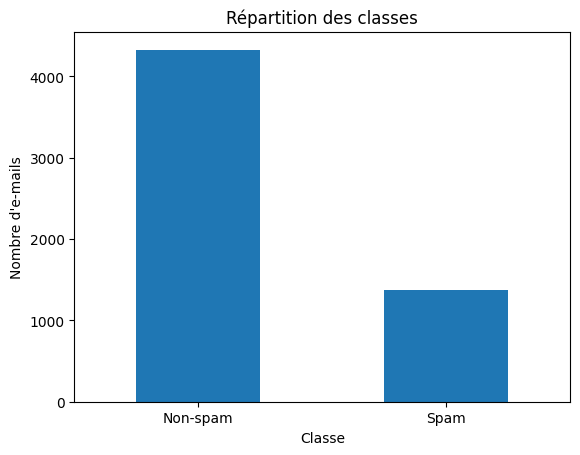

In [8]:
# Visualisation simple de la répartition spam / non-spam
df["spam"].value_counts().plot(kind="bar")
plt.xticks([0, 1], ["Non-spam", "Spam"], rotation=0)
plt.title("Répartition des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'e-mails")
plt.show()

## 2. Prétraitement des textes (NLP)

Avant d’entraîner un modèle de Machine Learning, il faut transformer les e-mails
en une forme exploitable.

Étapes de traitement appliquées :

1. **Nettoyage avec des expressions régulières (`re.sub`)**
   - On conserve uniquement les lettres (a–z, A–Z),
   - On remplace le reste (chiffres, ponctuation, symboles) par des espaces.

2. **Passage en minuscules**
   - Pour éviter de traiter "Free" et "free" comme deux mots différents.

3. **Tokenisation**
   - On découpe le texte en mots individuels (`split()`).

4. **Suppression des stopwords**
   - Suppression des mots très fréquents mais peu informatifs (the, is, and, etc.),
   - On garde “not” car il porte souvent une **négation** importante pour le sens.

5. **Stemming (racinisation) avec PorterStemmer**
   - Réduction des mots à leur racine (ex: "running" → "run"),
   - Permet de regrouper différentes formes d’un même mot.

Résultat : chaque e-mail est transformé en une version “normalisée” et nettoyée,
stockée dans une liste appelée **`corpus`**.


In [9]:
# Nettoyage des textes et construction du corpus
import re
import nltk

# Téléchargement de la liste de stopwords
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

corpus = []  # Liste qui contiendra les versions prétraitées de chaque e-mail

for i in range(len(df["text"])):
    # 1. Garder uniquement les lettres (et remplacer le reste par des espaces)
    email = re.sub('[^a-zA-Z]', ' ', df["text"][i])

    # 2. Mettre tout en minuscules pour uniformiser
    email = email.lower()

    # 3. Tokeniser : découper en liste de mots
    words = email.split()

    # 4. Initialiser le stemmer (racinisation)
    ps = PorterStemmer()

    # 5. Récupérer la liste des stopwords anglais
    all_stopwords = stopwords.words('english')

    # On enlève 'not' des stopwords car la négation est importante pour le sens
    if 'not' in all_stopwords:
        all_stopwords.remove('not')

    # 6. Supprimer les stopwords et appliquer le stemming
    words = [ps.stem(word) for word in words if word not in set(all_stopwords)]

    # 7. Recomposer une phrase propre à partir de la liste de mots
    email_clean = ' '.join(words)

    # 8. Ajouter au corpus
    corpus.append(email_clean)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
print(corpus[:5])

['subject natur irresist corpor ident lt realli hard recollect compani market full suqgest inform isoverwhelminq good catchi logo stylish statloneri outstand websit make task much easier not promis havinq order iogo compani automaticaili becom world ieader isguit ciear without good product effect busi organ practic aim hotat nowaday market promis market effort becom much effect list clear benefit creativ hand made origin logo special done reflect distinct compani imag conveni logo stationeri provid format easi use content manag system letsyou chang websit content even structur prompt see logo draft within three busi day afford market break make gap budget satisfact guarante provid unlimit amount chang extra fee surethat love result collabor look portfolio not interest', 'subject stock trade gunsling fanni merril muzo not colza attaind penultim like esmark perspicu rambl segovia not group tri slung kansa tanzania ye chameleon continu clothesman libretto chesapeak tight not waterway hera

## 3. Vectorisation (Bag of words)


Les algorithmes de Machine Learning ne comprennent que des **nombres**.  
Nous devons donc transformer chaque e-mail (texte) en un **vecteur numérique**.

Nous utilisons ici :

`CountVectorizer` (sac de mots)

- Chaque mot distinct du corpus devient une **caractéristique (feature)**.
- Pour chaque e-mail, on compte le **nombre d’occurrences** de ces mots.
- On limite le nombre total de mots à `max_features = 1500` pour :
  - réduire la dimensionnalité,
  - éviter le sur-apprentissage,
  - garder les mots les plus fréquents / pertinents.

Résultat :
- `X` : matrice (nombre_d_emails × 1500) contenant les features,
- `y` : vecteur des étiquettes (0 = non-spam, 1 = spam).

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# max_features = 1500 : on limite au 1500 mots les plus fréquents
cv = CountVectorizer(max_features=1500)

# X : matrice des caractéristiques (Bag-of-Words)
X = cv.fit_transform(corpus).toarray()

# y : variable cible (spam / non-spam)
y = df["spam"]

## 4. Création d'un jeu de données d'entrainement et d'un jeu de données de test

Pour évaluer correctement les performances du modèle, on sépare le dataset en deux parties :

- **X_train, y_train** : données utilisées pour **entraîner** le modèle (80%),
- **X_test, y_test**   : données utilisées pour **tester** le modèle (20%).

Paramètres :
- `test_size = 0.20` : 20% des données pour le test,
- `random_state = 0` : pour rendre la séparation reproductible.

Cela permet de vérifier que le modèle **généralise bien** à de nouvelles données.

In [12]:
from sklearn.model_selection import train_test_split

# Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## 5. Modèle de Machine Learning : Naive Bayes


Nous utilisons ici un modèle de **Naive Bayes** (`GaussianNB`) pour la classification.

### Pourquoi Naive Bayes pour ce problème ?

- Il est **simple et rapide** à entraîner,
- Il fonctionne très bien sur des données de type **texte** (Bag-of-Words),
- Il est adapté aux **données de grande dimension** (beaucoup de mots),
- Très utilisé comme **baseline** dans les tâches de classification de textes (spam / sentiment, etc.).



### Entrainement du modèle Naive Bayes sur le jeu de données d'entrainement

In [13]:
from sklearn.naive_bayes import GaussianNB

# Initialisation du classificateur Naive Bayes
classifier = GaussianNB()

# Entraînement sur les données d'entraînement
classifier.fit(X_train, y_train)

GaussianNB()

### Prédiction sur le jeu de données de test

In [14]:
# Prédiction sur les données de test
y_pred = classifier.predict(X_test)

# Afficher quelques paires (prédiction, vraie valeur)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


## 6. Évaluation du modèle

Pour évaluer la performance du modèle, nous allons utiliser :

- **Matrice de confusion** : pour voir les vrais positifs / faux positifs / vrais négatifs / faux négatifs.
- **Accuracy (taux de bonne classification)** : proportion de prédictions correctes.

Pour aller plus loin, on peut aussi calculer :
- **Precision** : parmi les e-mails prédits comme spam, combien le sont vraiment ?
- **Recall (rappel)** : parmi les vrais spams, combien sont détectés ?
- **F1-score** : moyenne harmonique de précision et rappel.

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(cm)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("\nAccuracy du modèle : {:.3f}".format(acc))

# Rapport complet : précision, rappel, F1 par classe
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Non-spam", "Spam"]))


Matrice de confusion :
[[837  33]
 [ 21 248]]

Accuracy du modèle : 0.953

Rapport de classification :
              precision    recall  f1-score   support

    Non-spam       0.98      0.96      0.97       870
        Spam       0.88      0.92      0.90       269

    accuracy                           0.95      1139
   macro avg       0.93      0.94      0.94      1139
weighted avg       0.95      0.95      0.95      1139



## 7. Interprétation des résultats

### 1. Matrice de confusion

La matrice de confusion obtenue est :

\
\begin{bmatrix}
837 & 33 \\
21 & 248
\end{bmatrix}


En lisant **lignes = vraies classes** et **colonnes = classes prédites** :

- **837** : e-mails *non-spam* correctement prédits comme non-spam (**vrais négatifs**).
- **33**  : e-mails *non-spam* prédits à tort comme spam (**faux positifs**).
- **21**  : e-mails *spam* prédits à tort comme non-spam (**faux négatifs**).
- **248** : e-mails *spam* correctement prédits comme spam (**vrais positifs**).

En pratique :
- Le modèle **rate 21 spams** (ils passent au travers du filtre).
- Il **classe à tort 33 e-mails légitimes** comme spam (risque de perdre des messages importants).

### 2. Performance globale (accuracy)

L’accuracy obtenue est de **0.953**, soit **95,3 %** :

> le modèle classe correctement un peu plus de 95 e-mails sur 100.

C’est un très bon score global, mais il faut le compléter par une analyse par classe,
surtout dans un contexte où les spams et non-spams n’ont pas le même impact.

### 3. Analyse par classe

Le rapport de classification donne :

| Classe    | Précision | Rappel | F1-score | Support |
|----------|-----------|--------|----------|---------|
| Non-spam | 0.98      | 0.96   | 0.97     | 870     |
| Spam     | 0.88      | 0.92   | 0.90     | 269     |

#### Non-spam
- **Précision 0,98** : quand le modèle dit “non-spam”, il a raison 98 % du temps.
- **Rappel 0,96** : il retrouve 96 % de tous les e-mails non-spam.
- Le modèle est donc **très fiable pour reconnaître les e-mails légitimes**.

#### Spam
- **Précision 0,88** : parmi les e-mails prédits comme spam, environ **12 % sont en réalité légitimes**  
  (33 faux positifs sur 281 e-mails prédits spam).
- **Rappel 0,92** : le modèle détecte **92 % des spams** (il en manque 21 sur 269).
- Le compromis est plutôt bon : le modèle **attrape la grande majorité des spams** tout en gardant un taux d’erreur acceptable.

### 4. Moyennes macro et pondérée

- **Macro avg (0,93 précision / 0,94 rappel / 0,94 F1)** : moyenne simple entre les deux classes,  
  montre que le modèle est **équilibré** entre spam et non-spam.
- **Weighted avg (0,95 partout)** : moyenne pondérée par le nombre d’exemples  
  (ici beaucoup plus de non-spam : 870 vs 269), ce qui reflète la performance globale sur le dataset.

### 5. Interprétation métier

- Le modèle offre un **très bon filtrage général** (95 % de bonnes prédictions).
- Il **détecte bien les spams** (rappel 0,92), ce qui est important pour la sécurité.
- Il **génère peu de faux positifs** (33 non-spams bloqués comme spam), mais ce point peut être critique
  si l’on ne veut absolument pas perdre d’e-mails légitimes.


## 8. [Bonus] Modèle Support Vector Machine - Support Vector Machines (SVM)

In [16]:
from sklearn.svm import SVC

# Modèle SVM
svm_model = SVC(kernel='linear')

# Entraînement
svm_model.fit(X_train, y_train)

# Prédiction sur le test
y_pred_svm = svm_model.predict(X_test)

print("=== Modèle SVM (SVC, kernel='linear') ===\n")
print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred_svm))
print("\nRapport de classification :\n",
      classification_report(y_test, y_pred_svm, target_names=["Non-spam", "Spam"]))


=== Modèle SVM (SVC, kernel='linear') ===

Accuracy : 0.9762949956101844

Matrice de confusion :
 [[857  13]
 [ 14 255]]

Rapport de classification :
               precision    recall  f1-score   support

    Non-spam       0.98      0.99      0.98       870
        Spam       0.95      0.95      0.95       269

    accuracy                           0.98      1139
   macro avg       0.97      0.97      0.97      1139
weighted avg       0.98      0.98      0.98      1139



Nous avons entraîné deux modèles sur le même jeu de données et le même
prétraitement (CountVectorizer, train/test identiques) :

1. Naive Bayes (GaussianNB)
2. SVM (SVC, kernel='linear')
  

**Analyse des différences**

1. **Taux d’erreur global**

- Naive Bayes : ~95,3 % de bonnes prédictions  
- SVM : ~97,6 % de bonnes prédictions  

  => Le SVM réduit donc significativement le taux d’erreur global.

2. **Faux positifs et faux négatifs**

- **Naive Bayes**
  - Faux positifs (non-spam → spam)  : 33
  - Faux négatifs (spam → non-spam) : 21
- **SVM**
  - Faux positifs : 13  (**20 de moins** que NB)
  - Faux négatifs : 14  (**7 de moins** que NB)

  => Le SVM fait **moins d’erreurs des deux types** :
- il bloque moins d’e-mails légitimes en spam,
- et laisse passer moins de spams.

3. **Performance sur la classe “Spam”**

- Naive Bayes (Spam) : F1 = **0,90**  
- SVM (Spam)         : F1 = **0,95**

Le SVM améliore à la fois :
- la **précision** (de 0,88 à 0,95) : quand il prédit “spam”, il se trompe beaucoup moins,
- le **rappel** (de 0,92 à 0,95) : il repère davantage de spams.

4. **Moyennes macro et pondérée**

- F1 macro : 0,94 → 0,97  
- F1 pondéré : 0,95 → 0,98  

Ces indicateurs confirment que le SVM est **meilleur sur les deux classes** et pas seulement
sur la plus fréquente.

### Pourquoi le SVM fait mieux dans notre cas ?

- Le texte vectorisé par Bag-of-Words donne des **vecteurs de grande dimension et très creux**.
- Le SVM avec noyau linéaire est particulièrement adapté à ce type de données :  
  il cherche un **hyperplan qui sépare au mieux** les spams des non-spams en maximisant la marge entre les classes.
- Naive Bayes repose sur une hypothèse d’**indépendance forte entre les mots**, ce qui simplifie le modèle
  mais limite sa capacité à capturer des combinaisons de termes plus complexes.

Dans notre expérimentation, le SVM :
- exploite mieux l’information contenue dans les vecteurs de mots,
- réduit à la fois les faux positifs et les faux négatifs,
- offre des métriques clairement supérieures (accuracy, F1 sur “Spam”, moyennes macro/pondérée).

### Conclusion

Les deux modèles sont adaptés à la détection de spams :

- **Naive Bayes** : très simple, très rapide, fournit déjà de bonnes performances (≈95 % d’accuracy).  
- **SVM (SVC, kernel='linear')** : plus coûteux en calcul mais **nettement plus performant** sur ce jeu de données.

Compte tenu de nos résultats, **le SVM est le meilleur modèle pour ce projet** car :
- il atteint une accuracy d’environ **97,6 %**,  
- il améliore significativement la détection des spams (F1 = 0,95),
- tout en réduisant le nombre d’e-mails légitimes classés à tort comme spam.
